# THE BATTLE OF CITIES

---------------

### PART 1

---------------

#### 1. A description of the problem and a discussion of the background.

As a traveler, I want to know where to plan my next trip. So I decided to make a city ranking. In this ranking will be included the global score of the city, the score of touring (tourism), relaxation, sociability and sportiveness. Every tourist wants to know if the next city break that they will make will have everything they need and they want to know that broadly speaking, not doing so much research to begin with.       

#### 2. A description of the data and how it will be used to solve the problem.

How I will be able to compute the scores? Well, all these scores are covered by data gathered from Foursquare API. I can count the number of hotels/motels, airports, museums/art galleries/monuments that are in that city in a 20km range (we want to cover even the biggest city) and compute the tourism score for that city by adding a weight to every kind of place. Same goes for the other scores. A global score will have the same principle, but will be formed by the scores from tourism, relaxation, sociability and sportiveness (with their corresponding weights as well).

---------------

### PART 2

---------------

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

try:
    from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
except:
    !conda install -c conda-forge geopy --yes 
    from geopy.geocoders import Nominatim

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas import json_normalize

import seaborn as sns
import matplotlib.pyplot as plt

try:
    import folium # plotting library
except:
    !conda install -c conda-forge folium=0.5.0 --yes
    import folium # plotting library

print('Libraries imported.')

### Define Foursquare Credentials and Version

In [ ]:
CLIENT_ID = 'B5B4IMMGPFMB3KLNMBP4C31ZLMMHUYCOE4TD3LXIB4WCBGWC' # your Foursquare ID
CLIENT_SECRET = 'WG0SXI3NNVW13CN4KRSESRMKHGHAXQDASIM1LVH5H2TV5QN2' # your Foursquare Secret
VERSION = '20180604'

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
search_queries_tourism = ['Hotel', 'Motel', 'Airport', 'Monument', 'Art', 'Museum']
search_queries_sociability = ['Restaurant', 'Bar', 'Pub', 'Cocktail', 'Coffee', 'Club', 'Disco', 'Lounge', 'Fast-Food', 'Cafe']
search_queries_relaxing = ['Park', 'Beach', 'Pool', 'Spa']
search_queries_sportiveness = ['Stadium', 'Gym', 'Fitness', 'Aerobic', 'Martial Art', 'Box', 'Footbal', 'Basketball', 'Tennis', 'Baseball', 'Voleyball']

search_queries = [search_queries_tourism, search_queries_sociability, search_queries_relaxing, search_queries_sportiveness]

In [ ]:
radius = 20000
LIMIT = 500
addresses = ['Bucharest, RO', 'Paris, FR', 'Rome, IT', 'Berlin, DE', 
             'Madrid, ES', 'Barcelona, ES', 'Tokyo, JP', 'Beijing, CN', 
             'New Delhi, IN', 'London, GB', 'New York City, NY', 'Moscow, RU', 
             'Amsterdam, NL', 'Atena, GR', 'Prague, CZ', 'Vienna, AT', 
             'Budapest, HU', 'Istanbul, TR', 'Sofia, BG', 'Kabul, AF',
            ]
latitude_list, longitude_list = [], []

x = len(addresses)
rankings = pd.DataFrame({"City":addresses,
                         "Tourism Places Count":np.zeros(x), 
                         "Tourism Score":np.zeros(x),
                         "Sociability Places Count":np.zeros(x),
                         "Sociability Score":np.zeros(x),
                         "Relaxing Places Count":np.zeros(x),
                         "Relaxing Score":np.zeros(x),
                         "Sportiveness Places Count":np.zeros(x),
                         "Sportiveness Score":np.zeros(x),
                         "Global Score":np.zeros(x),
                        })

for address in addresses:
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    latitude_list.append(latitude)
    longitude = location.longitude
    longitude_list.append(longitude)
    print(f"{address} --> latitude = {latitude}, longitude = {longitude}")
    
    Tourism = pd.DataFrame()
    Sociability = pd.DataFrame()
    Relaxing = pd.DataFrame()
    Sportiveness = pd.DataFrame()
    
    for k, search_queries_categ in enumerate(search_queries):
        for search_query in search_queries_categ:

#             print(f"Looking for...{search_query}")
            
            # Define the corresponding URL
            url = f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={latitude},{longitude}&v={VERSION}&query={search_query}&radius={radius}&limit={LIMIT}'

            # Send the GET Request and examine the results
            results = requests.get(url).json()

            # Get relevant part of JSON and transform it into a *pandas* dataframe
            # assign relevant part of JSON to venues
            venues = results['response']['venues']

            # tranform venues into a dataframe
            dataframe = json_normalize(venues)

            # Define information of interest and filter dataframe
            # keep only columns that include venue name, and anything that is associated with location
            filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
            try:
                dataframe_filtered = dataframe.loc[:, filtered_columns]
            except:
                continue

            # filter the category for each row
            dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
            dataframe_filtered_1 = dataframe_filtered[dataframe_filtered['categories'] == search_query]
            if dataframe_filtered_1.shape[0] == 0:
                dataframe_filtered_1 = dataframe_filtered[dataframe_filtered['categories'].str.contains(search_query, na=False)]
                if dataframe_filtered_1.shape[0] == 0:
                    dataframe_filtered_1 = dataframe_filtered

            # clean column names by keeping only last term
            dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
            
            if k == 0:
                Tourism = pd.concat([Tourism, dataframe_filtered], axis=0)
            if k == 1:
                Sociability = pd.concat([Sociability, dataframe_filtered], axis=0)
            if k == 2:
                Relaxing = pd.concat([Relaxing, dataframe_filtered], axis=0)
            if k == 3:
                Sportiveness = pd.concat([Sportiveness, dataframe_filtered], axis=0)
                
    row = rankings[rankings.City == address].index[0]
    rankings.loc[row, 'Tourism Places Count'] = Tourism.shape[0]
    rankings.loc[row, 'Sociability Places Count'] = Sociability.shape[0]
    rankings.loc[row, 'Relaxing Places Count'] = Relaxing.shape[0]
    rankings.loc[row, 'Sportiveness Places Count'] = Sportiveness.shape[0]

In [ ]:
for address in addresses:
    row = rankings[rankings.City == address].index[0]
    rankings.loc[row, 'Tourism Score'] = (rankings.loc[row, 'Tourism Places Count'] - min(rankings.loc[:, 'Tourism Places Count']))/(max(rankings.loc[:, 'Tourism Places Count']) - min(rankings.loc[:, 'Tourism Places Count']))
    rankings.loc[row, 'Sociability Score'] = (rankings.loc[row, 'Sociability Places Count'] - min(rankings.loc[:, 'Sociability Places Count']))/(max(rankings.loc[:, 'Sociability Places Count']) - min(rankings.loc[:, 'Sociability Places Count']))
    rankings.loc[row, 'Relaxing Score'] = (rankings.loc[row, 'Relaxing Places Count'] - min(rankings.loc[:, 'Relaxing Places Count']))/(max(rankings.loc[:, 'Relaxing Places Count']) - min(rankings.loc[:, 'Relaxing Places Count']))
    rankings.loc[row, 'Sportiveness Score'] = (rankings.loc[row, 'Sportiveness Places Count'] - min(rankings.loc[:, 'Sportiveness Places Count']))/(max(rankings.loc[:, 'Sportiveness Places Count']) - min(rankings.loc[:, 'Sportiveness Places Count']))
    rankings.loc[row, 'Global Score'] = rankings.loc[row, 'Tourism Score']*0.4 + rankings.loc[row, 'Sociability Score']*0.2 + rankings.loc[row, 'Relaxing Score']*0.3 + rankings.loc[row, 'Sportiveness Score']*0.1

In [ ]:
rankings

In [ ]:
rankings[["City", "Tourism Places Count", "Tourism Score"]].sort_values('Tourism Score', ascending=False)

In [ ]:
rankings[["City", "Sociability Places Count", "Sociability Score"]].sort_values('Sociability Score', ascending=False)

In [ ]:
rankings[["City", "Relaxing Places Count", "Relaxing Score"]].sort_values('Relaxing Score', ascending=False)

In [ ]:
rankings[["City", "Sportiveness Places Count", "Sportiveness Score"]].sort_values('Sportiveness Score', ascending=False)

In [ ]:
rankings[["City", "Global Score"]].sort_values('Global Score', ascending=False)

#### Plot the data

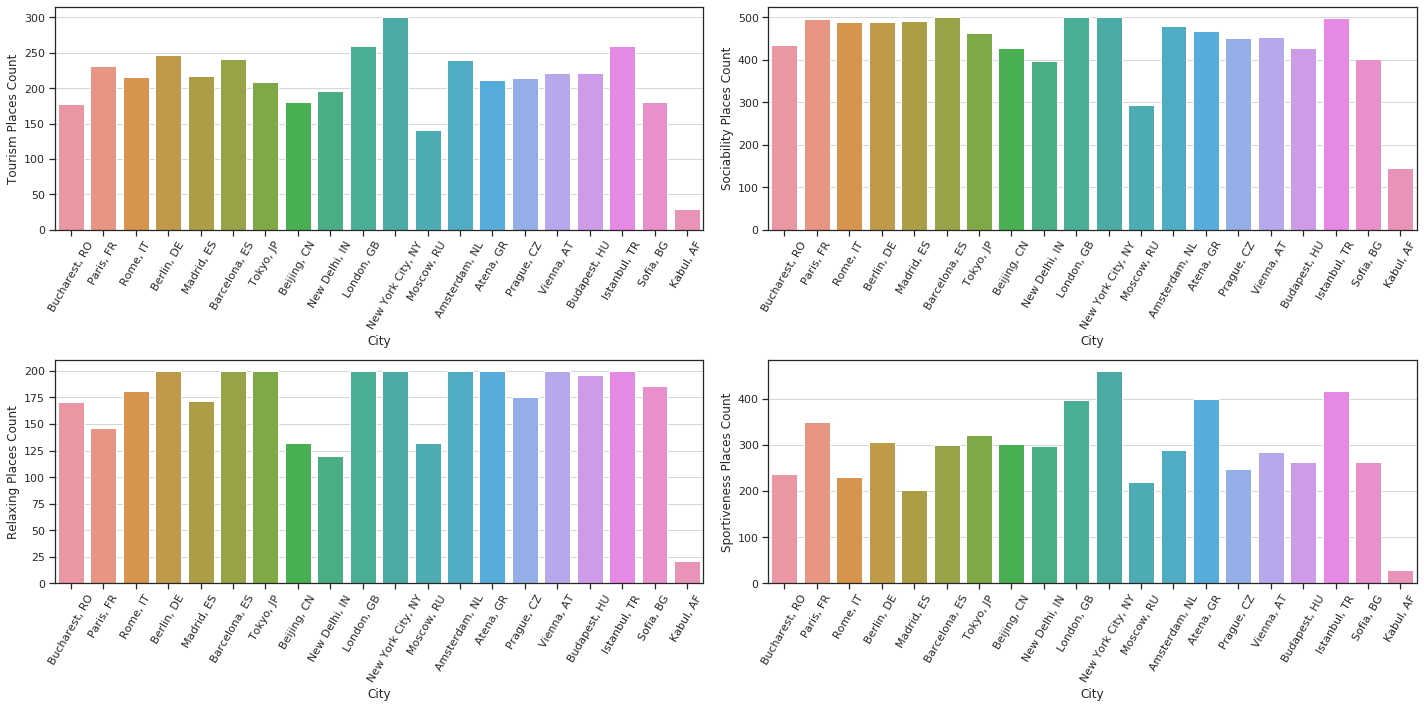

In [64]:
sns.set(style="ticks", palette="Set1", color_codes=True)
f, axes = plt.subplots(2, 2, figsize=(20, 10))
                       
t_count = sns.barplot(y='Tourism Places Count', x='City', data=rankings, ax=axes[0,0])
t_count.set_xticklabels(t_count.get_xticklabels(), rotation=60)
axes[0,0].grid(axis='y', alpha=0.8)

so_count = sns.barplot(y='Sociability Places Count', x='City', data=rankings, ax=axes[0,1])
so_count.set_xticklabels(so_count.get_xticklabels(), rotation=60)
axes[0,1].grid(axis='y', alpha=0.8)

r_count = sns.barplot(y='Relaxing Places Count', x='City', data=rankings, ax=axes[1,0])
r_count.set_xticklabels(r_count.get_xticklabels(), rotation=60)
axes[1,0].grid(axis='y', alpha=0.8)

sp_count = sns.barplot(y='Sportiveness Places Count', x='City', data=rankings, ax=axes[1,1])
sp_count.set_xticklabels(sp_count.get_xticklabels(), rotation=60)
axes[1,1].grid(axis='y', alpha=0.8)

plt.tight_layout()
plt.savefig('Places_count.png')

In [ ]:
sns.set(style="ticks", palette="Set2", color_codes=True)
f, axes = plt.subplots(2, 2, figsize=(20, 10))
                       
t_score = sns.barplot(y='Tourism Score', x='City', data=rankings, ax=axes[0,0])
t_score.set_xticklabels(t_score.get_xticklabels(), rotation=45)
axes[0,0].grid(axis='y', alpha=0.8)

so_score = sns.barplot(y='Sociability Score', x='City', data=rankings, ax=axes[0,1])
so_score.set_xticklabels(so_score.get_xticklabels(), rotation=45)
axes[0,1].grid(axis='y', alpha=0.8)

r_score = sns.barplot(y='Relaxing Score', x='City', data=rankings, ax=axes[1,0])
r_score.set_xticklabels(r_score.get_xticklabels(), rotation=45)
axes[1,0].grid(axis='y', alpha=0.8)

sp_score = sns.barplot(y='Sportiveness Score', x='City', data=rankings, ax=axes[1,1])
sp_score.set_xticklabels(sp_score.get_xticklabels(), rotation=45)
axes[1,1].grid(axis='y', alpha=0.8)

plt.tight_layout()

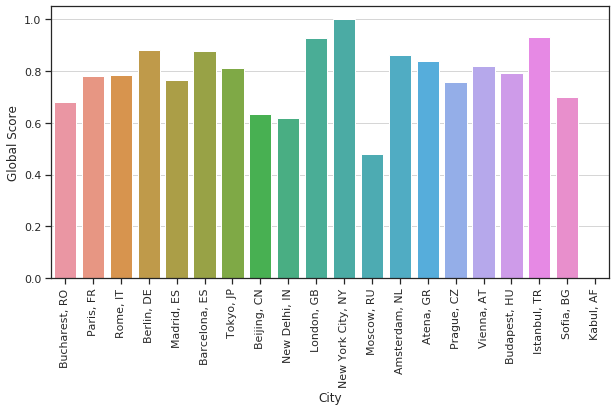

In [65]:
plt.figure(figsize=(10, 5))
g_score = sns.barplot(y='Global Score', x='City', data=rankings)
g_score.set_xticklabels(g_score.get_xticklabels(), rotation=90)
plt.grid(axis='y', alpha=0.8)
plt.savefig('global_score.png')
plt.show()

#### Let's visualize all the cities we get the data from

In [ ]:
venues_map = folium.Map() # generate map centred around the Conrad Hotel

for lat, lng, label in zip(latitude_list, longitude_list, addresses):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [ ]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=10) # generate map centred around the Conrad Hotel

folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup=address,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

for lat, lng, label in zip(Tourism.lat, Tourism.lng, Tourism.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
    
for lat, lng, label in zip(Sociability.lat, Sociability.lng, Sociability.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(venues_map)
    
for lat, lng, label in zip(Relaxing.lat, Relaxing.lng, Relaxing.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map)
    
for lat, lng, label in zip(Sportiveness.lat, Sportiveness.lng, Sportiveness.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='magenta',
        popup=label,
        fill = True,
        fill_color='magenta',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map